# Previsão de Custo Anual – SaúdeViva  
Este projeto apresenta um estudo baseado na empresa fictícia **SaúdeViva**, que oferece planos personalizados com previsões de custo calculadas via *Machine Learning*.

A análise considera fatores individuais, como idade, altura, peso, tabagismo, número de filhos e região de residência, para garantir maior transparência na precificação.

# 1 – Importando Bibliotecas e Carregando Dados


In [1]:
# Manipulação e visualização de dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Extração de dados
from src.utils import carregar_dados
raw = carregar_dados(caminho="dados/Train_Data.csv")

# Pré-processamento
from sklearn.preprocessing import PowerTransformer
from scipy.stats import ks_2samp

# Métricas de aprendizado
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# 2 – Análise Exploratória de Dados (EDA)


In [2]:
# Visualização do DataFrame
display(raw)


,age,sex,bmi,smoker,region,children,charges
0,21.000000,male,25.745000,no,northeast,2,3279.868550
1,36.976978,female,25.744165,yes,southeast,3,21454.494239
2,18.000000,male,30.030000,no,southeast,1,1720.353700
3,37.000000,male,30.676891,no,northeast,3,6801.437542
4,58.000000,male,32.010000,no,southeast,1,11946.625900
...,...,...,...,...,...,...,...
3625,48.820767,female,41.426984,no,northwest,4,10987.324964
3626,38.661977,female,26.202557,no,southeast,2,11735.844352
3627,56.000000,male,40.300000,no,southwest,0,10602.385000
3628,48.061207,female,34.930624,no,southeast,1,8976.140452


In [3]:
# Quantidade de linhas
# Quantidade de colunas
# Nome de cada coluna
# Quantidade de valores não nulos em cada coluna
# Tipo de dado em cada coluna
# Uso de memória pelo DataFrame
raw.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3630 entries, 0 to 3629
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       3630 non-null   float64
 1   sex       3630 non-null   object 
 2   bmi       3630 non-null   float64
 3   smoker    3630 non-null   object 
 4   region    3630 non-null   object 
 5   children  3630 non-null   int64  
 6   charges   3630 non-null   float64
dtypes: float64(3), int64(1), object(3)
memory usage: 198.6+ KB


In [4]:
# Quantidade de valores nulos em cada coluna
raw.isnull().sum()


age         0
sex         0
bmi         0
smoker      0
region      0
children    0
charges     0
dtype: int64

In [5]:
# Estatística descritiva das colunas numéricas
# count: quantidade de valores não nulos
# mean: média
# std: desvio padrão
# min: 0% (valor mínimo)
# Q1: 25%
# Q2: 50% (mediana)
# Q3: 75%
# max: 100% (valor máximo)
print(raw.describe(include=[np.number]))


               age          bmi     children       charges
count  3630.000000  3630.000000  3630.000000   3630.000000
mean     38.887036    30.629652     2.503581  12784.808644
std      12.151029     5.441307     1.712568  10746.166743
min      18.000000    15.960000     0.000000   1121.873900
25%      29.000000    26.694526     1.000000   5654.818262
50%      39.170922    30.200000     3.000000   9443.807222
75%      48.343281    34.100000     4.000000  14680.407505
max      64.000000    53.130000     5.000000  63770.428010


In [6]:
# Estatística descritiva das colunas do tipo object
# unique: quantidade de valores distintos
# top: valor mais frequente (moda)
# freq: frequência do valor mais frequente
print(raw.describe(include="object"))


         sex smoker     region
count   3630   3630       3630
unique     2      2          4
top     male     no  southeast
freq    2029   3070       1021


In [7]:
# Valor mais frequente (moda) de cada coluna
print(raw.mode().iloc[[0]])


    age   sex   bmi smoker     region  children   charges
0  19.0  male  32.3     no  southeast       0.0  1137.011


In [8]:
# Número de valores únicos em cada coluna
raw.nunique()


age         1589
sex            2
bmi         2322
smoker         2
region         4
children       6
charges     2951
dtype: int64

In [9]:
# Visualização dos valores nas colunas categóricas
# Usar em colunas com poucos valores únicos
# Identificar se há valores redundantes
# Identificar se há espaços em branco
print(raw["sex"].unique())
print(raw["smoker"].unique())
print(raw["region"].unique())


['male' 'female']
['no' 'yes']
['northeast' 'southeast' 'northwest' 'southwest']


In [10]:
# Quantidade de linhas duplicadas no DataFrame
raw.duplicated().sum()


np.int64(679)

In [11]:
# Identificação de linhas duplicadas no dataset
# Se houver um identificador (ID), mantém-se o registro original e remove as duplicatas
# Se não houver ID, pode ser um erro na coleta dos dados — então remove-se todas as duplicadas
print(raw[raw.duplicated()])


            age     sex        bmi smoker     region  children       charges
2217  19.000000    male  30.590000     no  northwest         0   1639.563100
2952  34.000000    male  25.270000     no  northwest         1   4894.753300
2953  33.000000  female  28.270000     no  southeast         1   4779.602300
2954  33.398132    male  29.352224     no  southwest         4   6216.387358
2955  39.000000    male  27.539985     no  southeast         5   8844.634442
...         ...     ...        ...    ...        ...       ...           ...
3625  48.820767  female  41.426984     no  northwest         4  10987.324964
3626  38.661977  female  26.202557     no  southeast         2  11735.844352
3627  56.000000    male  40.300000     no  southwest         0  10602.385000
3628  48.061207  female  34.930624     no  southeast         1   8976.140452
3629  37.598865  female  25.219233     no  northeast         3   7027.698968

[679 rows x 7 columns]


### 2.1 – Distribuição assimétrica (Skewness) das colunas numéricas
- Positivo ou negativo (0.0 $\to$ 0.5) → Distribuição aproximadamente simétrica  
    - Não necessita transformação para ser usada nos modelos  
- Positivo ou negativo (0.5 $\to$ 1.0) → Assimetria moderada  
    - Transformação com raiz quadrada pode melhorar a precisão de alguns modelos  
- Positivo ou negativo (1.0 $\to \infty$) → Assimetria alta  
    - Transformação Yeo-Johnson pode melhorar a precisão dos modelos


In [12]:
# Distribuição assimétrica das colunas numéricas
# Skewness (assimetria) representa o grau de distorção dos dados em relação à média
# Assimetria positiva: concentração maior de valores baixos
# Assimetria negativa: concentração maior de valores altos
raw.skew(numeric_only=True)


age         0.049292
bmi         0.353485
children   -0.009063
charges     1.774523
dtype: float64

# 3 – Pré-processamento de dados


In [13]:
# Visualização inicial dos dados brutos do DataFrame
display(raw)


,age,sex,bmi,smoker,region,children,charges
0,21.000000,male,25.745000,no,northeast,2,3279.868550
1,36.976978,female,25.744165,yes,southeast,3,21454.494239
2,18.000000,male,30.030000,no,southeast,1,1720.353700
3,37.000000,male,30.676891,no,northeast,3,6801.437542
4,58.000000,male,32.010000,no,southeast,1,11946.625900
...,...,...,...,...,...,...,...
3625,48.820767,female,41.426984,no,northwest,4,10987.324964
3626,38.661977,female,26.202557,no,southeast,2,11735.844352
3627,56.000000,male,40.300000,no,southwest,0,10602.385000
3628,48.061207,female,34.930624,no,southeast,1,8976.140452


In [14]:
# Passando dados brutos para o dataframe que será pré-processado
df = raw
# Convertendo object para category
df[["sex","smoker","region"]] = raw[["sex","smoker","region",]].astype("category")
# Limitando casas decimais
df["age"] = raw["age"].astype("int64")
df["bmi"] = raw["bmi"].round(2)
df["charges"] = raw["charges"].round(2)

### 3.1 One-Hot Encoding nas variáveis possuem somente dois valores

In [15]:
# One-Hot Encoding nas variáveis categóricas para otimizar a performance nos modelos
df = pd.get_dummies(df, drop_first=True)


### 3.2 Classificando BMI

In [16]:
# Classificação do IMC em categorias
def categorize_bmi(bmi):
    if bmi < 18.5:
        return "baixo"
    elif 18.5 <= bmi < 25:
        return "normal"
    elif 25 <= bmi < 30:
        return "sobrepeso"
    else:
        return "obesidade"

df["bmi_category"] = raw["bmi"].apply(categorize_bmi).astype("category")


### 3.3 Removendo duplicatas que não possuem ID
- `df.drop_duplicates(keep=False)` remove as duplicatas, incluindo a primeira
- `df.drop_duplicates(keep="first")` remove as duplicatas, manténdo a primeira

In [17]:
# Remoção de todas as linhas duplicadas, já que não há ID único
df = df.drop_duplicates(keep=False)

# Remoção de duplicatas dos dados brutos para manter consistência nas próximas etapas de pré-processamento
raw = raw.drop_duplicates(keep=False)

# Verificação de duplicatas restantes
print(df.duplicated().sum())


0


### 3.4 – Aplicando transformação Yeo-Johnson em *charges*
- A transformação Yeo-Johnson foi escolhida porque funciona tanto para assimetria positiva quanto negativa


In [18]:
# Criação do objeto PowerTransformer com o método Yeo-Johnson
pt = PowerTransformer(method="yeo-johnson")

# Aplicação da transformação na variável 'charges'
df["charges"] = pt.fit_transform(raw[["charges"]])

# Verificação da nova assimetria (skewness) após a transformação
print(f"charges: {df['charges'].skew()}")


charges: 0.0003358591599711067


Antes da transformação, o skewness era 1.774523, indicando uma alta assimetria positiva. Isso significa que os dados apresentavam uma concentração maior de valores baixos e uma cauda longa com valores elevados. Esse tipo de distribuição pode impactar análises estatísticas e comprometer a performance de modelos preditivos.

Após a transformação, o skewness caiu para 0.000336 — um valor próximo de zero —, indicando que a distribuição está muito mais simétrica. Isso torna os dados mais adequados para modelos como regressão linear, que tendem a apresentar melhor desempenho com distribuições normalizadas.


### 3.5 – Teste de normalidade Kolmogorov-Smirnov
- Indicado para amostras com mais de 50 observações


In [19]:
# Criar uma amostra com distribuição normal baseada nos dados de 'charges'
normal_sample = np.random.normal(np.mean(df["charges"]), np.std(df["charges"]), size=len(df))

# Executar o teste de Kolmogorov-Smirnov
stat, p_value = ks_2samp(df["charges"], normal_sample)

# Exibir resultados
print(f"Estatística do teste: {stat:.4f} — quanto maior, menor a evidência de normalidade")
print(f"P-valor: {p_value:.4f} — se p < 0.05, rejeita-se a hipótese de normalidade")

# Interpretar o resultado
if p_value > 0.05:
    print("Os dados seguem uma distribuição normal.")
else:
    print("Os dados não seguem uma distribuição normal.")


Estatística do teste: 0.0515 — quanto maior, menor a evidência de normalidade
P-valor: 0.0048 — se p < 0.05, rejeita-se a hipótese de normalidade
Os dados não seguem uma distribuição normal.


### 3.6 - Dados pré-processados

In [20]:
# Exibe as variáveis numéricas, booleanas e categóricas após o pré-processamento
display(df.select_dtypes(include=["number", "bool", "category"]))

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,bmi_category
0,21,25.74,2,-1.413093,True,False,False,False,False,sobrepeso
1,36,25.74,3,1.038779,False,True,False,True,False,sobrepeso
2,18,30.03,1,-2.266364,True,False,False,True,False,obesidade
3,37,30.68,3,-0.455343,True,False,False,False,False,obesidade
4,58,32.01,1,0.279515,True,False,False,True,False,obesidade
...,...,...,...,...,...,...,...,...,...,...
2944,42,36.55,3,1.912921,True,True,False,True,False,obesidade
2947,43,35.53,2,0.880876,True,True,False,True,False,obesidade
2949,50,26.77,4,0.213525,False,False,True,False,False,sobrepeso
2950,49,31.40,4,0.193904,False,False,True,False,False,obesidade


# 4 – Visualização de Dados
- A seguir, serão exploradas as distribuições e relações entre as variáveis do dataset, com foco na identificação de padrões, outliers e correlações úteis para a modelagem preditiva.


### 4.1 Distribuições univariadas (histogramas com KDE)

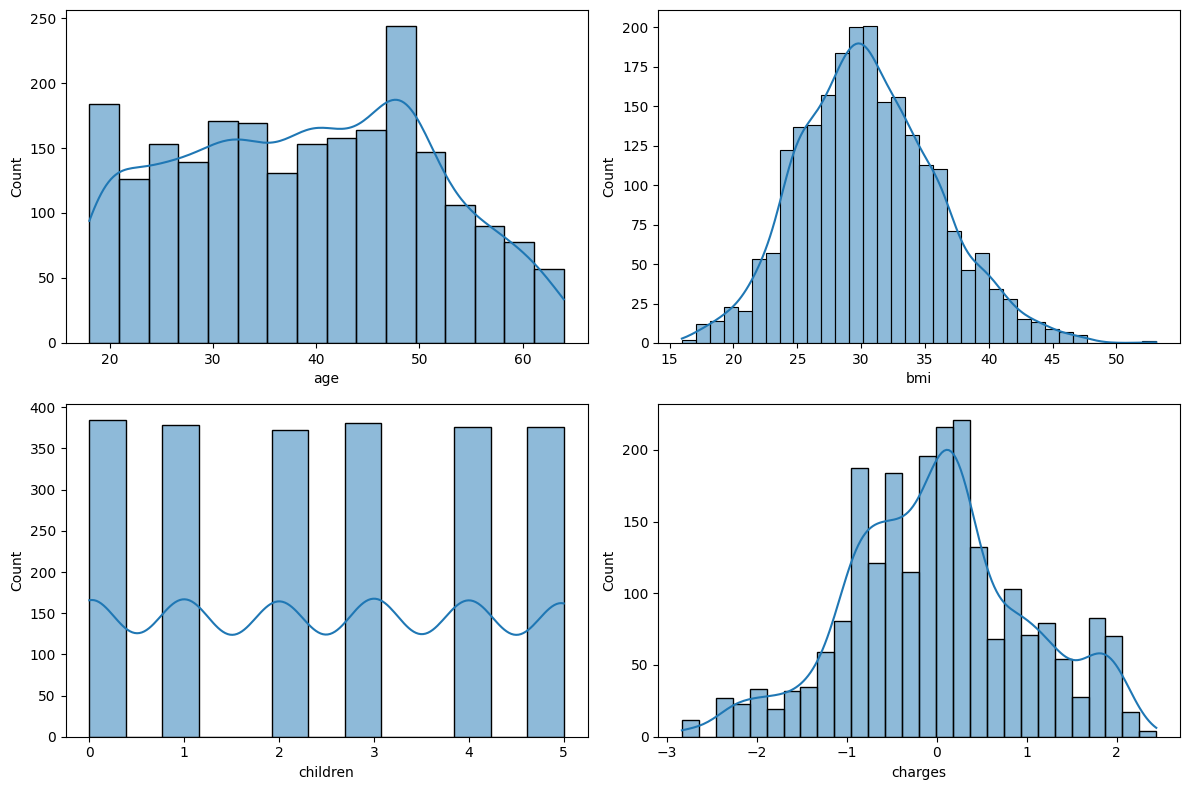

In [21]:
# Gráficos de barras com KDE para todas as colunas numéricas
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2 linhas, 2 colunas
sns.histplot(data=df, x="age", kde=True, ax=axes[0, 0])      # linha 0, coluna 0
sns.histplot(data=df, x="bmi", kde=True, ax=axes[0, 1])      # linha 0, coluna 1
sns.histplot(data=df, x="children", kde=True, ax=axes[1, 0]) # linha 1, coluna 0
sns.histplot(data=df, x="charges", kde=True, ax=axes[1, 1])  # linha 1, coluna 1
plt.tight_layout()  # Espaçamento automático entre os gráficos
plt.show()          # Exibir visualização


### 4.2 Boxplots para detectar outliers

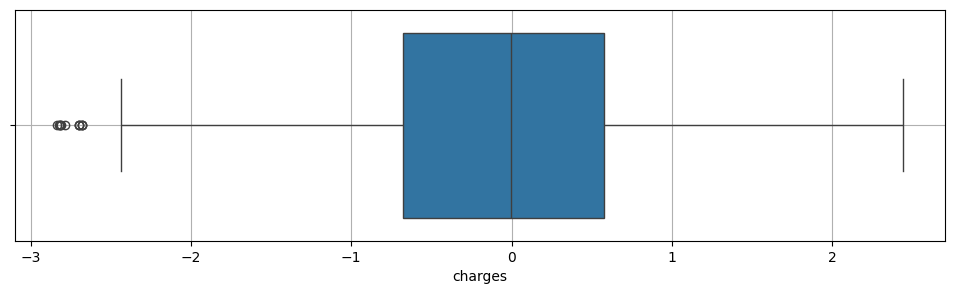

In [22]:
# Define o tamanho da figura (largura, altura)
plt.figure(figsize=(12, 3))

# Cria um boxplot horizontal para a coluna 'charges'
# Usar 'x' gera um gráfico horizontal; usar 'y' geraria um gráfico vertical
sns.boxplot(x=df["charges"])

# Adiciona uma grade de fundo para facilitar a leitura dos valores
plt.grid(True)

# Exibe o gráfico na tela
plt.show()


# 5 – Treinamento Baseline

In [23]:
# Seleção das colunas para o treinamento do modelo
df_baseline = df[["age", "sex_male", "smoker_yes", "region_northwest", "region_southeast", "region_southwest"]]

# Definição das variáveis independentes (features)
x = df_baseline.iloc[:, :-1]  # Todas as linhas, exceto a última coluna

# Definição da variável dependente (target)
y = df_baseline.iloc[:, -1]   # Todas as linhas, apenas a última coluna


# 5.1 – Predição do modelo baseline

In [24]:
# Predição baseline: o modelo sempre prevê a média dos valores de y
y_pred = [y.mean()] * len(y)

# Avaliação da performance da predição comparada aos valores reais
print(f"MAE (Erro Absoluto Médio): {mean_absolute_error(y, y_pred):.3f} — quanto menor, melhor")
print(f"MSE (Erro Quadrático Médio): {mean_squared_error(y, y_pred):.3f} — quanto menor, melhor")
print(f"RMSE (Raiz do Erro Quadrático Médio): {np.sqrt(mean_squared_error(y, y_pred)):.3f} — quanto menor, melhor")
print(f"R² (Coeficiente de Determinação): {r2_score(y, y_pred):.3f} — quanto mais próximo de 1, melhor")


MAE (Erro Absoluto Médio): 0.362 — quanto menor, melhor
MSE (Erro Quadrático Médio): 0.181 — quanto menor, melhor
RMSE (Raiz do Erro Quadrático Médio): 0.425 — quanto menor, melhor
R² (Coeficiente de Determinação): 0.000 — quanto mais próximo de 1, melhor


# 6 – Divisão treino e teste dos dados

In [25]:
# Importação da biblioteca de divisão do conjunto de dados
from sklearn.model_selection import train_test_split

# Divide os dados em conjuntos de treino e teste
# x e y são separados em:
# - x_train: entradas para treino
# - x_test: entradas para teste
# - y_train: rótulos para treino
# - y_test: rótulos para teste
# test_size=0.2 → 20% dos dados para teste, 80% para treino
# random_state=0 garante reprodutibilidade: mesma divisão toda vez que o código for executado

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# 7 - Testando Modelos

# 7.1 - Regressão Linear

In [26]:
# Importação da biblioteca de Regressão Linear
from sklearn.linear_model import LinearRegression
lr_reg = LinearRegression()
lr_reg = lr_reg.fit(x_train, y_train)

# Predição
y_pred = lr_reg.predict(x_test)

# Scores
print(f"MAE: {mean_absolute_error(y_test, y_pred):.3f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}")
print(f"R² : {r2_score(y_test, y_pred):.3f}")

MAE: 0.261
MSE: 0.123
RMSE: 0.351
R² : 0.298


### 7.2 Regressão Ridge

In [27]:
# Importação da biblioteca de Regressão Ridge
from sklearn.linear_model import Ridge
ridge_reg = Ridge()
ridge_reg = ridge_reg.fit(x_train, y_train)

# Predição
y_pred = ridge_reg.predict(x_test)

# Scores
print(f"MAE: {mean_absolute_error(y_test, y_pred):.3f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}")
print(f"R² : {r2_score(y_test, y_pred):.3f}")


MAE: 0.261
MSE: 0.123
RMSE: 0.351
R² : 0.298


### 7.3 Regressão Lasso

In [28]:
# mportação da biblioteca Regressão Lasso
from sklearn.linear_model import Lasso
lasso_reg = Lasso()
lasso_reg = lasso_reg.fit(x_train, y_train)

# Predição
y_pred = lasso_reg.predict(x_test)

# Scores
print(f"MAE: {mean_absolute_error(y_test, y_pred):.3f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}")
print(f"R² : {r2_score(y_test, y_pred):.3f}")


MAE: 0.358
MSE: 0.176
RMSE: 0.419
R² : -0.001


### 7.4 XGBoost Regressor

In [29]:
# Importação da biblioteca XGBoost Regressor
from xgboost import XGBRegressor
xgb_reg = XGBRegressor()
xgb_reg = xgb_reg.fit(x_train, y_train)

# Predição
y_pred = xgb_reg.predict(x_test)

# Scores
print(f"MAE: {mean_absolute_error(y_test, y_pred):.3f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}")
print(f"R² : {r2_score(y_test, y_pred):.3f}")


MAE: 0.223
MSE: 0.126
RMSE: 0.355
R² : 0.281


### 7.5 LightGBM Regressor

In [30]:
# Importação da bilioteca LightGBM Regressor
from lightgbm import LGBMRegressor
lgbm_reg = LGBMRegressor(verbose=-1)
lgbm_reg = lgbm_reg.fit(x_train, y_train)

# Predição
y_pred = lgbm_reg.predict(x_test)

# Scores
print(f"MAE: {mean_absolute_error(y_test, y_pred):.3f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}")
print(f"R² : {r2_score(y_test, y_pred):.3f}")

MAE: 0.229
MSE: 0.118
RMSE: 0.343
R² : 0.329


### 7.6 Random Forest Regressor

In [31]:
# Importação da biblioteca Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor()
rf_reg = rf_reg.fit(x_train, y_train)

# Predição
y_pred = rf_reg.predict(x_test)

# Scores
print(f"MAE: {mean_absolute_error(y_test, y_pred):.3f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}")
print(f"R² : {r2_score(y_test, y_pred):.3f}")


MAE: 0.215
MSE: 0.127
RMSE: 0.356
R² : 0.278


# 8 – Otimização dos modelos candidatos
- Os modelos escolhidos foram Random Forest e LightGBM devido à boa precisão de ambos


### 8.1 – Ajustando hiperparâmetros e fazendo avaliação da qualidade do modelo
- Para ajustar os hiperparâmetros, será usada a Bayesian Optimization
- Para avaliar a qualidade do modelo, será usada a Cross-Validation


### 8.2 - Otimizando Random Frest Regressor

In [32]:
# Importação da biblioteca Bayesian Optimization
from bayes_opt import BayesianOptimization
# Importação da biblioteca de avaliação Cross-Validation
from sklearn.model_selection import cross_val_score

# Função de avaliação dos hiperparâmetros
def rf_evaluate(n_estimators, max_depth, min_samples_split, min_samples_leaf):
    model = RandomForestRegressor(
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        min_samples_split=int(min_samples_split),
        min_samples_leaf=int(min_samples_leaf),
        random_state=42
    )
    scores = cross_val_score(model, x_train, y_train, cv=5, scoring='neg_mean_squared_error')
    return np.mean(scores)

# Dicionário com os hiperparâmetros
param_bounds = {
    'n_estimators': (50, 300),
    'max_depth': (5, 30),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 4)
}

# Execução da Bayesian Optimization
optimizer = BayesianOptimization(f=rf_evaluate, pbounds=param_bounds, random_state=42)
optimizer.maximize(init_points=5, n_iter=15)

# Obtenção dos melhores hiperparâmetros
best_params = optimizer.max['params']
rf_reg = RandomForestRegressor(
    n_estimators=int(best_params['n_estimators']),
    max_depth=int(best_params['max_depth']),
    min_samples_split=int(best_params['min_samples_split']),
    min_samples_leaf=int(best_params['min_samples_leaf']),
    random_state=42
)

# Treinamento do modelo
rf_reg.fit(x_train, y_train)

# Predição do modelo
y_pred = rf_reg.predict(x_test)

# Avaliação
print(f"MAE: {mean_absolute_error(y_test, y_pred):.3f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}")
print(f"R²: {r2_score(y_test, y_pred):.3f}")


|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | -0.1186   | 14.36     | 3.852     | 7.856     | 199.7     |
| 2         | -0.1117   | 8.9       | 1.468     | 2.465     | 266.5     |
| 3         | -0.1189   | 20.03     | 3.124     | 2.165     | 292.5     |
| 4         | -0.1259   | 25.81     | 1.637     | 3.455     | 95.85     |
| 5         | -0.1187   | 12.61     | 2.574     | 5.456     | 122.8     |
| 6         | -0.1117   | 8.74      | 2.153     | 3.048     | 267.7     |
| 7         | -0.1168   | 30.0      | 4.0       | 10.0      | 252.4     |
| 8         | -0.1084   | 5.0       | 4.0       | 10.0      | 248.5     |
| 9         | -0.1083   | 5.0       | 4.0       | 2.0       | 233.3     |
| 10        | -0.1086   | 5.0       | 4.0       | 10.0      | 50.0      |
| 11        | -0.1176   | 30.0      | 4.0       | 2.0       | 50.0      |
| 12        | -0.1172   | 30.0      | 

### 8.3 - Otimizando LightGBM Regressor

In [33]:
# Importação da biblioteca Bayesian Optimization
from bayes_opt import BayesianOptimization
# Importação da biblioteca de avaliação Cross-Validation
from sklearn.model_selection import cross_val_score

# Função de avaliação dos hiperparâmetros
def lgbm_evaluate(n_estimators, max_depth, num_leaves, learning_rate):
    model = LGBMRegressor(
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        num_leaves=int(num_leaves),
        learning_rate=learning_rate,
        random_state=42,
        verbose=-1  # Silencia os logs
    )
    scores = cross_val_score(model, x_train, y_train, cv=5, scoring='neg_mean_squared_error')
    return np.mean(scores)

# Dicionário com os hiperparâmetros
param_bounds = {
    'n_estimators': (50, 300),
    'max_depth': (5, 30),
    'num_leaves': (20, 50),
    'learning_rate': (0.01, 0.3)
}

# Execução da Bayesian Optimization
optimizer = BayesianOptimization(f=lgbm_evaluate, pbounds=param_bounds, random_state=42)
optimizer.maximize(init_points=5, n_iter=15)

# Obtenção dos melhores hiperparâmetros
best_params = optimizer.max['params']
lgbm_reg = LGBMRegressor(
    n_estimators=int(best_params['n_estimators']),
    max_depth=int(best_params['max_depth']),
    num_leaves=int(best_params['num_leaves']),
    learning_rate=best_params['learning_rate'],
    random_state=42,
    verbose=-1  # Silencia os logs no treinamento final
)

# Treinamento do modelo
lgbm_reg.fit(x_train, y_train)

# Predição do modelo
y_pred = lgbm_reg.predict(x_test)

# Avaliação
print(f"MAE: {mean_absolute_error(y_test, y_pred):.3f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}")
print(f"R²: {r2_score(y_test, y_pred):.3f}")


|   iter    |  target   | learni... | max_depth | n_esti... | num_le... |
-------------------------------------------------------------------------
| 1         | -0.1227   | 0.1186    | 28.77     | 233.0     | 37.96     |
| 2         | -0.1119   | 0.05525   | 8.9       | 64.52     | 45.99     |
| 3         | -0.1196   | 0.1843    | 22.7      | 55.15     | 49.1      |
| 4         | -0.1203   | 0.2514    | 10.31     | 95.46     | 25.5      |
| 5         | -0.1196   | 0.09823   | 18.12     | 158.0     | 28.74     |
| 6         | -0.12     | 0.2197    | 21.7      | 105.7     | 21.92     |
| 7         | -0.1253   | 0.01281   | 9.239     | 64.74     | 45.45     |
| 8         | -0.1128   | 0.0113    | 6.009     | 166.6     | 30.56     |
| 9         | -0.1296   | 0.2915    | 22.74     | 298.5     | 31.22     |
| 10        | -0.1206   | 0.1467    | 9.012     | 250.5     | 22.9      |
| 11        | -0.1267   | 0.2821    | 22.66     | 162.5     | 49.95     |
| 12        | -0.1219   | 0.2348    | 

### 8.4 – Conclusão da otimização e trade-off
- Random Forest Regressor apresentou um resultado melhor após a otimização, porém sua performance é inferior à do LightGBM. Levando a escalabilidade em consideração, o LightGBM foi o modelo escolhido, pois poderá performar melhor com uma quantidade maior de dados no futuro.


# 9 – Teste de Generalização (Overfitting e Underfitting)

- **MAE = Erro Absoluto Médio**
    - Se **MAE Treino < MAE Teste**, pode indicar **overfitting**.
    - Se **MAE Treino e MAE Teste** forem altos e **R²** for baixo, pode indicar **underfitting**.
    - Se **MAE Treino e MAE Teste** forem altos e próximos, pode indicar **underfitting**.

- **RMSE = Raiz do Erro Quadrático Médio**
    - Se **RMSE Treino < RMSE Teste**, pode indicar **overfitting**.
    - Se **RMSE Treino e RMSE Teste** forem altos e **R²** for baixo, pode indicar **underfitting**.
    - Se **RMSE Treino e RMSE Teste** forem altos e próximos, pode indicar **underfitting**.

- **Comparação entre RMSE e MAE**
    - Se **RMSE Teste ≈ MAE Teste**, modelo **bem ajustado**, com poucos erros extremos.
    - Se **RMSE Teste > MAE Teste**, modelo aceitável, mas pode haver **alguns outliers**.
    - Se **RMSE Teste for 2x ou mais o MAE Teste**, o modelo pode estar **mal ajustado**, indicando erros grandes.


In [34]:
# Predição no conjunto de treino
y_train_pred = lgbm_reg.predict(x_train)

# Predição no conjunto de teste
y_test_pred = lgbm_reg.predict(x_test)

# Cálculo do erro em ambos os conjuntos
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# Exibição das métricas
print(f"MAE Treino: {mae_train:.3f}")
print(f"MAE Teste: {mae_test:.3f}")
print(f"RMSE Treino: {rmse_train:.3f}")
print(f"RMSE Teste: {rmse_test:.3f}")
print(f"R² Treino: {r2_train:.3f}")
print(f"R² Teste: {r2_test:.3f}")


MAE Treino: 0.205
MAE Teste: 0.225
RMSE Treino: 0.313
RMSE Teste: 0.337
R² Treino: 0.461
R² Teste: 0.354


# 10 – Gráficos de Curva de Aprendizado
- Mostra como o modelo aprende, de acordo com as métricas, à medida que o tamanho dos dados de treino (que ele ainda não conhece) vai aumentando.

### **Como interpretar os dados?**
1️⃣ **MAE (Erro Absoluto Médio)**  
💡 Representa o erro médio nas previsões do modelo.  
- Se a linha **MAE Treino** estiver **muito abaixo da MAE Teste**, pode indicar **overfitting**.  
- Se ambas estiverem **altas e próximas**, pode indicar **underfitting**.

2️⃣ **RMSE (Raiz do Erro Quadrático Médio)**  
💡 Similar ao MAE, mas **penaliza erros maiores**, então valores altos podem indicar **outliers**.  
- Se o **RMSE Teste for muito maior que o RMSE Treino**, há risco de **overfitting**.  
- Se ambos forem altos, pode ser **underfitting**.  
- Se o **RMSE estiver muito maior que o MAE**, pode significar que o modelo comete erros grandes ocasionalmente.

3️⃣ **R² (Coeficiente de Determinação)**  
💡 Mede **quanto o modelo explica a variação dos dados** (valores entre **0 e 1**, quanto maior, melhor).  
- Se o **R² Treino for muito maior que o R² Teste**, é sinal de **overfitting**.  
- Se o **R² Teste for muito baixo (<0.3)**, pode indicar **underfitting**.

---

### 🔍 **Como saber se o modelo está bom?**  
✔ Se as curvas de treino e teste forem **parecidas e com valores baixos**, significa que o modelo está bem ajustado.  
✔ Se houver **grande diferença** entre treino e teste, pode ser **overfitting**.  
✔ Se ambas as métricas forem **altas e o R² for baixo**, pode ser **underfitting**.


# 10.1 – Curva de aprendizado do modelo escolhido
- Serve para medir a precisão do modelo à medida que o conjunto de dados vai aumentando


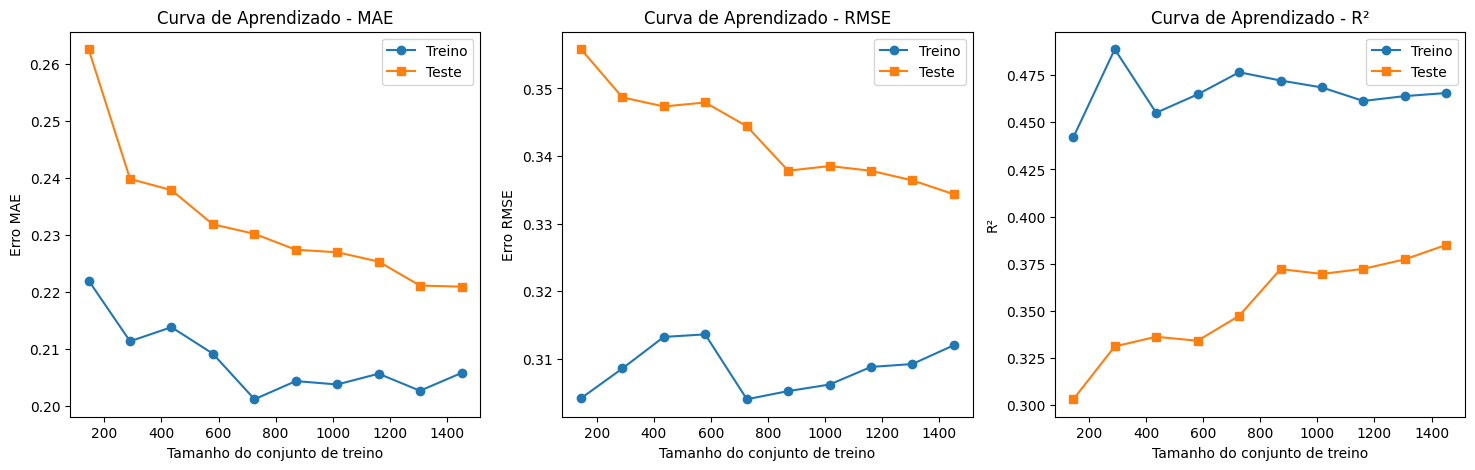

In [35]:
# Importação da função de curva de aprendizado
from sklearn.model_selection import learning_curve

# Cálculo das curvas de aprendizado para MAE
train_sizes, train_scores, test_scores = learning_curve(
    lgbm_reg, x_train, y_train, cv=5, scoring="neg_mean_absolute_error", train_sizes=np.linspace(0.1, 1.0, 10)
)
train_mean = -np.mean(train_scores, axis=1)
test_mean = -np.mean(test_scores, axis=1)

# Cálculo das curvas de aprendizado para RMSE
train_sizes_rmse, train_scores_rmse, test_scores_rmse = learning_curve(
    lgbm_reg, x_train, y_train, cv=5, scoring="neg_root_mean_squared_error", train_sizes=np.linspace(0.1, 1.0, 10)
)
train_mean_rmse = -np.mean(train_scores_rmse, axis=1)
test_mean_rmse = -np.mean(test_scores_rmse, axis=1)

# Cálculo das curvas de aprendizado para R²
train_sizes_r2, train_scores_r2, test_scores_r2 = learning_curve(
    lgbm_reg, x_train, y_train, cv=5, scoring="r2", train_sizes=np.linspace(0.1, 1.0, 10)
)
train_mean_r2 = np.mean(train_scores_r2, axis=1)
test_mean_r2 = np.mean(test_scores_r2, axis=1)

# Plotagem dos gráficos
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# MAE
axs[0].plot(train_sizes, train_mean, label="Treino", marker="o")
axs[0].plot(train_sizes, test_mean, label="Teste", marker="s")
axs[0].set_xlabel("Tamanho do conjunto de treino")
axs[0].set_ylabel("Erro MAE")
axs[0].set_title("Curva de Aprendizado - MAE")
axs[0].legend()

# RMSE
axs[1].plot(train_sizes_rmse, train_mean_rmse, label="Treino", marker="o")
axs[1].plot(train_sizes_rmse, test_mean_rmse, label="Teste", marker="s")
axs[1].set_xlabel("Tamanho do conjunto de treino")
axs[1].set_ylabel("Erro RMSE")
axs[1].set_title("Curva de Aprendizado - RMSE")
axs[1].legend()

# R²
axs[2].plot(train_sizes_r2, train_mean_r2, label="Treino", marker="o")
axs[2].plot(train_sizes_r2, test_mean_r2, label="Teste", marker="s")
axs[2].set_xlabel("Tamanho do conjunto de treino")
axs[2].set_ylabel("R²")
axs[2].set_title("Curva de Aprendizado - R²")
axs[2].legend()

plt.show()


# 11 – Serialização do modelo (Salvando modelo treinado)
- Ao salvar (serializar) o modelo, ele não precisa ser treinado novamente


In [36]:
from src.utils import salvar_modelo
salvar_modelo(lgbm_reg)  # Salva o modelo no caminho padrão


# 11.1 – Desserialização do modelo (Carregando modelo treinado)


In [37]:
from src.utils import carregar_modelo
carregar_modelo()  # Carrega o modelo a partir do caminho padrão


LGBMRegressor(learning_rate=np.float64(0.055245405728306586), max_depth=8,
              n_estimators=64, num_leaves=45, random_state=42, verbose=-1)

# 11.2 – Testando modelo carregado


In [38]:
# Carrega o modelo salvo no caminho padrão
lgbm_reg_carregado = carregar_modelo()

# Teste do modelo carregado
y_pred_carregado = lgbm_reg_carregado.predict(x_test)

# Avaliação
print(f"MAE: {mean_absolute_error(y_test, y_pred_carregado):.3f}")
print(f"MSE: {mean_squared_error(y_test, y_pred_carregado):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_carregado)):.3f}")
print(f"R²: {r2_score(y_test, y_pred_carregado):.3f}")


MAE: 0.225
MSE: 0.113
RMSE: 0.337
R²: 0.354


## 12 – Conclusão do Projeto

Neste projeto, desenvolvi um modelo de aprendizado de máquina para prever indicadores relacionados a planos de saúde, utilizando **LightGBM** como algoritmo principal. A análise envolveu pré-processamento de dados, ajuste de hiperparâmetros e avaliação de desempenho com métricas como **MAE (0.225), MSE (0.113), RMSE (0.337) e R² (0.354)**.

Os resultados indicam que há oportunidades de aprimoramento, especialmente no aumento da acurácia do modelo por meio de técnicas de *feature engineering* mais avançadas ou da exploração de modelos alternativos. No entanto, a abordagem demonstrou-se eficaz na captura de padrões relevantes nos dados.
